## Problema 1

Diseña un robot que se mueve en 1D con aceleración constante

Ejecución de ejemplo:

    %run -i code/filter.py
    o = ConstantAccelerationRobot(accel=0.1, mnoise=3)
    o.move_n_time_steps(n=30)
    real, measured = o.pos_history, o.m_history
    plot_moves (real, measured)


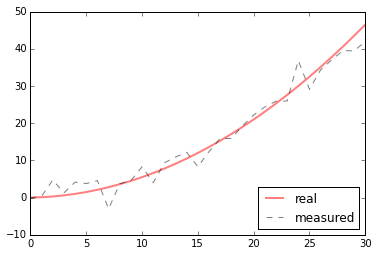

In [4]:
from IPython.display import Image
Image(filename='imgs/robot-accelerated.png')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class ConstantAccelerationRobot(object):
    
    def __init__ (self, init_pos=0., init_vel=0., accel=0., mnoise=0.1):
        self.pos   = init_pos
        self.vel   = init_vel
        self.accel = accel
        self.mnoise = mnoise
        self.pos_history = [self.pos]
        self.vel_history = [self.vel]
        self.m_history = [self.measure_position()]
        
    def measure_position(self):
        # --------------
        # TU CODIGO AQUI
        mi_medida = self.pos + np.random.normal(0,self.mnoise) if self.mnoise !=0 else self.pos
        return mi_medida
        # --------------
        
    def move(self):
        pass
        # --------------
        # TU CODIGO AQUI 
        self.pos += self.vel #    ... actualiza las variables self.vel y self.pos
        self.vel += self.accel
        #    ... anade la posicion y la medida tomada en las variables
        #        pos_history, vel_history y m_history
        self.pos_history.append(self.pos)
        self.vel_history.append(self.vel)
        self.m_history.append(self.measure_position())
        # --------------

    def move_n_time_steps(self, n):
        for t in range(n):
            self.move()

Comprueba tu código

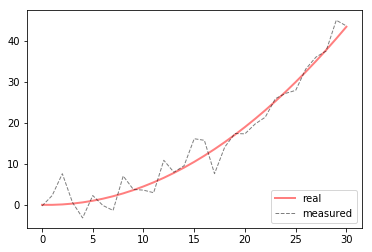

In [13]:
%run -i code/filter.py
o = ConstantAccelerationRobot(accel=0.1, mnoise=3)
o.move_n_time_steps(n=30)
real, measured = o.pos_history, o.m_history
plot_moves (real, measured)

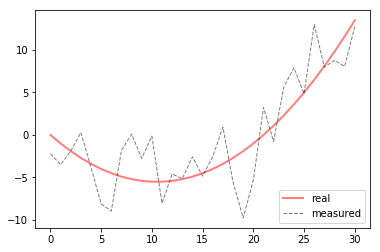

In [14]:
%run -i code/filter.py
o = ConstantAccelerationRobot(init_vel=-1, accel=0.1, mnoise=3)
o.move_n_time_steps(n=30)
real, measured = o.pos_history, o.m_history
plot_moves (real, measured)

## Problema 2

Observa el siguiente código en donde usamos un filtro de Kalman 2D (posición y velocidad) para estimar la posición de un robot con aceleración constante.

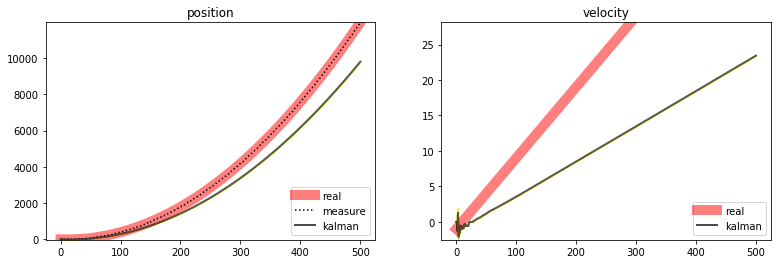

In [25]:
%run -i code/filter.py

def pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,
                                P,Q,R):

    init_x = [np.array([estimated_init_pos]), np.array([estimated_init_vel])]

    o = ConstantAccelerationRobot(init_pos=robot_pos, init_vel=robot_vel, accel=robot_accel, mnoise=R)
    o.move_n_time_steps(n=500)
    phist, mhist = o.pos_history, np.array(o.m_history)

    F = np.array([[1, 1], [0, 1]])  # state transition matrix
    H = np.array([[1, 0]])          # Measurement function

    k = KalmanFilter(dim_x=2, dim_z=1, P=P, R=R, Q=Q, F=F, H=H, init_x=init_x)
    xhist, Phist = k.filter_data(mhist)

    xhist = [[i[0][0], i[1][0]] for i in xhist]
    plot_kalman_position_velocity(phist, mhist, xhist, Phist, o.vel_history )

    
robot_pos, robot_vel, robot_accel      = 0., -1., 0.1
estimated_init_pos, estimated_init_vel = 0., 0.
P, R, Q                                = 1., 10., 0.

pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel, 
                            estimated_init_pos, estimated_init_vel,
                            P, Q, R)

La estimación de la posición diverge porque nuestro modelo físico es incorrecto ya que asume que no hay aceleración.

Diseña un filtro de Kalman de forma que:

- el estado esté compuesto por 3 variables (posición, velocidad y aceleración), de las cuales sólo podemos medir una
- la matriz $H$ haga corresponder nuestro estado de tres variables con la observación únicamente de la posición.
- la matriz $F$ represente el siguiente modelo:

$$ s^- = s + v + a $$
$$ v^- = v + a$$
$$ a^- = a $$

_En realidad, el modelo es $s^- = s + v\Delta t + a\Delta t^2$, pero lo simplificamos ya que asumimos que $\Delta t = 1$_

Respuesta esperada:

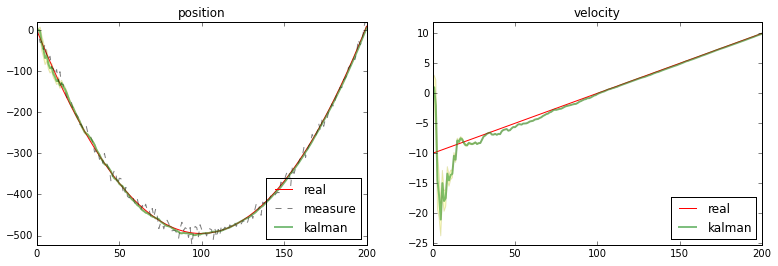

In [26]:
from IPython.display import Image
Image(filename='imgs/kalman-1.png')

In [44]:
%run -i code/filter.py


def pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R):
    
    # --- FIJATE COMO EL ESTADO AHORA TIENE TRES COMPONENTES ----
    init_x = [np.array([estimated_init_pos]), np.array([estimated_init_vel]), np.array([estimated_init_accel])]

    o = ConstantAccelerationRobot(init_pos=robot_pos, init_vel=robot_vel, accel=robot_accel, mnoise=R)
    o.move_n_time_steps(n=200)
    phist, mhist = o.pos_history, np.array(o.m_history)

    # -----------------
    # TU CODIGO AQUI
    F = np.array([[1, 1, 1], [0, 1, 1],[0, 0, 1]])  # state transition matrix
    H = np.array([[1, 0, 0]])     # Measurement function
    # -----------------
     
    k = KalmanFilter(dim_x=3, dim_z=1, P=P, R=R, Q=Q, F=F, H=H, init_x=init_x)
    xhist, Phist = k.filter_data(mhist)

    xhist = [[i[0][0], i[1][0]] for i in xhist]
    plot_kalman_position_velocity(phist, mhist, xhist, Phist, o.vel_history )


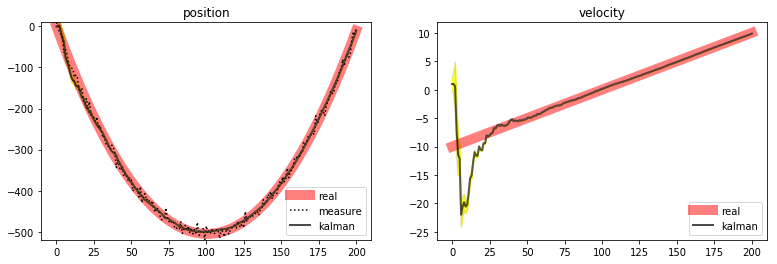

In [45]:
robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 1., 0.
P, R, Q                 = 1., 10., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R)

## Problema 3

Ejecuta el experimento anterior 4 veces con las siguientes variaciones:

- Con un gran error en la estimación inicial de la velocidad (init_vel=100)
- Con un gran error en la estimación inicial de la aceleración (init_accel=100)
- Con un gran ruido de medida ($R=100$)
- Con un gran ruido de medida ($R=100$) pero también con gran confianza en nuestras estimaciones iniciales ($P=0.001$)

Explica los resultados obtenidos

'\nEn este ejemplo como la Velocidad inicial Estimada presenta un valor tan alto le cuesta bastantes intentos al filtro de \nKalman para llegar a la posicion real igualmentr a la velocidad, ya que al empezar en un valor tan alto requiere mas unidades\nde tiempo para llegar a la velocidad real\n'

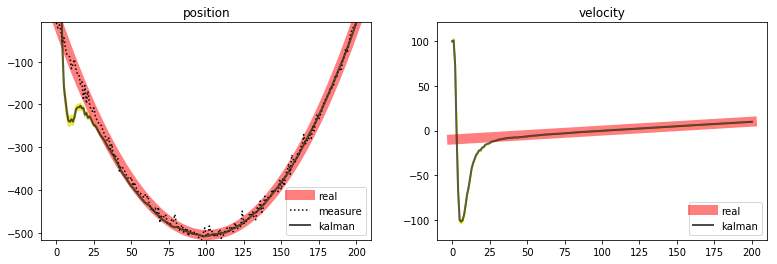

In [46]:
robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 100., 1.
P, R, Q                 = 1., 10., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,P,Q,R)
"""
En este ejemplo como la Velocidad inicial Estimada presenta un valor tan alto le cuesta bastantes intentos al filtro de 
Kalman para llegar a la posicion real igualmentr a la velocidad, ya que al empezar en un valor tan alto requiere mas unidades
de tiempo para llegar a la velocidad real
"""

'\nEn este ejemplo como la Aceleracion inicial Estimada presenta un valor tan alto le cuesta bastantes intentos al filtro de \nKalman para llegar a la velocidad real, ya que esta aumenta tan rapido luego le toca disminuir para llegar a la velocidad\nreal, ese es el por que de ese pico al principio de la gráfica de velocidad.\nEn el caso de la posición este no presenta muchos cambios, solo se tiene que adaptar ya que al principio por ser la vel\ntan elevada producto de la aceleración estte tiene que desacelerar para llegar a una posicion real.\n'

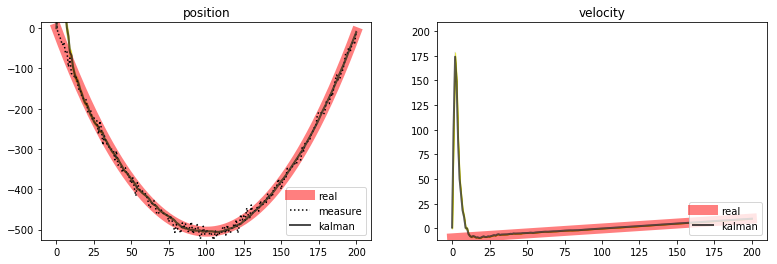

In [47]:
robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 1., 100.
P, R, Q                 = 1., 10., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,P,Q,R)
"""
En este ejemplo como la Aceleracion inicial Estimada presenta un valor tan alto le cuesta bastantes intentos al filtro de 
Kalman para llegar a la velocidad real, ya que esta aumenta tan rapido luego le toca disminuir para llegar a la velocidad
real, ese es el por que de ese pico al principio de la gráfica de velocidad.
En el caso de la posición este no presenta muchos cambios, solo se tiene que adaptar ya que al principio por ser la vel
tan elevada producto de la aceleración estte tiene que desacelerar para llegar a una posicion real.
"""

'\nEn este ejemplo como el ruido de la medicion presenta un valor tan alto que le cuesta tanto a la velocidad como a la posicion\nel acomodarse a la posicion real, este termina convergiendo por el numero de iteraciones, pero siempre se demora producto\nde la mala medicion\n'

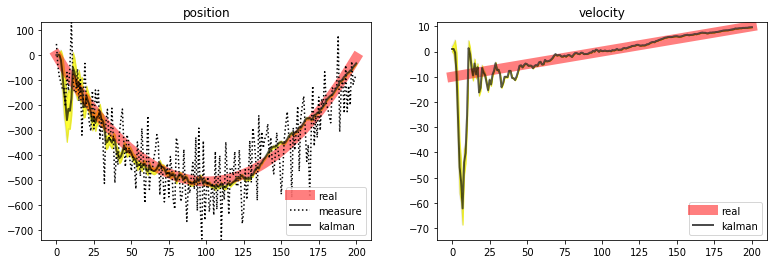

In [48]:
robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 1., 0.
P, R, Q                 = 1., 100., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R)
"""
En este ejemplo como el ruido de la medicion presenta un valor tan alto que le cuesta tanto a la velocidad como a la posicion
el acomodarse a la posicion real, este termina convergiendo por el numero de iteraciones, pero siempre se demora producto
de la mala medicion
"""

'\nAqui el ruido juega un papel que asimila el comportamiento real pero la estimacion inicial al ser tan alta y nuestros valores\niniciales tan distintos a los reales, nunca se logra recuperar kalman o por lo menos no en una cantidadde tiempo pequeño, \ntal y como lo vimos en ejemplos anteriores\n'

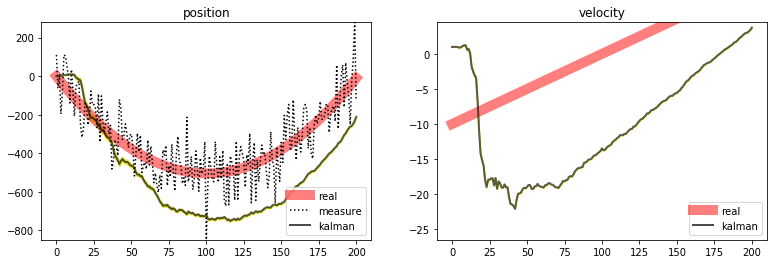

In [49]:
robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 1., 0.
P, R, Q                 = .001, 100., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R)
"""
Aqui el ruido juega un papel que asimila el comportamiento real pero la estimacion inicial al ser tan alta y nuestros valores
iniciales tan distintos a los reales, nunca se logra recuperar kalman o por lo menos no en una cantidadde tiempo pequeño, 
tal y como lo vimos en ejemplos anteriores
"""

## Problema 4 (EXTRA)

realiza el mismo experimento que en el Problema 2, pero ahora perdemos la señal entre los instantes de tiempo 70 y 130, y asumimos que la medida entre esos instantes de tiempo es constante e igual a la última medida vista en $t=70$.

Resultado esperado:

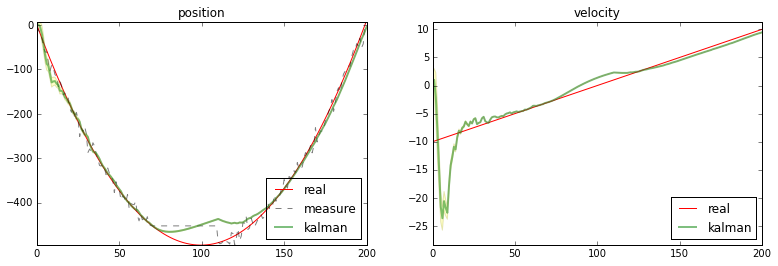

In [51]:
from IPython.display import Image
Image(filename='imgs/kalman-2.png')

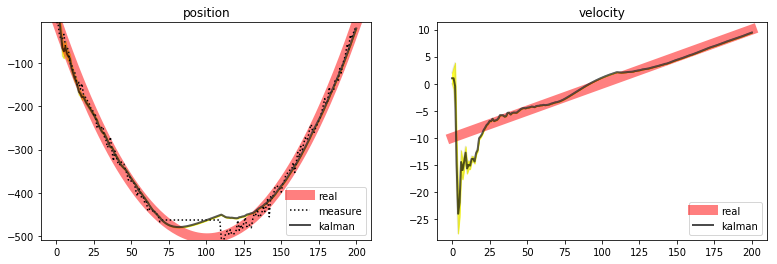

In [52]:
%run -i code/filter.py


def pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R):
    
    init_x = [np.array([estimated_init_pos]), np.array([estimated_init_vel]), np.array([estimated_init_accel])]

    o = ConstantAccelerationRobot(init_pos=robot_pos, init_vel=robot_vel, accel=robot_accel, mnoise=R)
    o.move_n_time_steps(n=200)
    phist, mhist = o.pos_history, np.array(o.m_history)

    # -----------------
    # TU CODIGO AQUI
    # modifica la señal en mhist entre las posiciones 70 y 110      
    mhist[70:110] = mhist[70] 

    # usa las mismas matrices del ejercicio anterior
    F = np.array([[1, 1, 1], [0, 1, 1],[0, 0, 1]])  # state transition matrix
    H = np.array([[1, 0, 0]])     # Measurement function
    # -----------------
     
    k = KalmanFilter(dim_x=3, dim_z=1, P=P, R=R, Q=Q, F=F, H=H, init_x=init_x)
    xhist, Phist = k.filter_data(mhist)

    xhist = [[i[0][0], i[1][0]] for i in xhist]
    plot_kalman_position_velocity(phist, mhist, xhist, Phist, o.vel_history )


robot_pos, robot_vel, robot_accel = 0., -10., 0.1
estimated_init_pos, estimated_init_vel, estimated_init_accel = 0., 1., 0.
P, R, Q                 = 1., 10., 0.
pos_vel_1D_tracking_example(robot_pos, robot_vel, robot_accel,
                                estimated_init_pos, estimated_init_vel,estimated_init_accel,
                                P,Q,R)